In [37]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

In [38]:
#scrape a single game shots. We will allow users to enter a base url
base_url = 'https://understat.com/match/'
match = str(input('Please enter the match id: '))
url = base_url+match

Please enter the match id: 17940


In [39]:
#Use requests to get the webpage and BeautifulSoup to parse the page
res = requests.get(url)
soup = BeautifulSoup(res.content, 'lxml')
scripts = soup.find_all('script')

In [40]:
#get only the shotsData
strings = scripts[1].string

In [41]:
# strip unnecessary symbols and get only JSON data 
ind_start = strings.index("('")+2 
ind_end = strings.index("')") 
json_data = strings[ind_start:ind_end] 
json_data = json_data.encode('utf8').decode('unicode_escape')

#convert string to json format
data = json.loads(json_data)

In [42]:
minute = []
xG = []
result = []
team = []
data_away = data['a']
data_home = data['h']

for index in range(len(data_home)):
    for key in data_home[index]:
        if key == 'minute':
            minute.append(data_home[index][key])
        if key == 'h_team':
            team.append(data_home[index][key])
        if key == 'xG':
            xG.append(data_home[index][key])
        if key == 'result':
            result.append(data_home[index][key])

for index in range(len(data_away)):
    for key in data_away[index]:
        if key == 'minute':
            minute.append(data_away[index][key])
        if key == 'a_team':
            team.append(data_away[index][key])
        if key == 'xG':
            xG.append(data_away[index][key])
        if key == 'result':
            result.append(data_away[index][key])

In [43]:
col_names = ['minute','xG','result','team']
df = pd.DataFrame([minute,xG,result,team],index=col_names)
df = df.T

In [44]:
df['xG'] = df['xG'].astype(float)
print(df)

   minute        xG       result        team
0       5  0.016727  MissedShots  Strasbourg
1      18  0.049531  MissedShots  Strasbourg
2      22  0.028703  MissedShots  Strasbourg
3      27  0.365609         Goal  Strasbourg
4      32  0.139794    SavedShot  Strasbourg
5      35  0.036602  MissedShots  Strasbourg
6      38  0.283086    SavedShot  Strasbourg
7      38  0.897973         Goal  Strasbourg
8      40  0.020444  MissedShots  Strasbourg
9      46  0.044501         Goal  Strasbourg
10     47  0.023099  BlockedShot  Strasbourg
11     59  0.422500  MissedShots  Strasbourg
12     63  0.970954         Goal  Strasbourg
13     76  0.023818  MissedShots  Strasbourg
14     78  0.025143  BlockedShot  Strasbourg
15     14  0.115151  MissedShots     Lorient
16     16  0.431877  MissedShots     Lorient
17     21  0.052286  MissedShots     Lorient
18     57  0.020137  MissedShots     Lorient
19     71  0.046753  BlockedShot     Lorient


In [45]:
#now that we have our dataframe set up, we are going to create some lists to plot the different xG values
#4 lists - home and away xg and minutes
#We start these with zero so our charts will start at 0
a_xG = [0]
h_xG= [0]
home=[data_home[0]['h_team']]
a_min = [0]
h_min = [0]
away=[data_home[0]['a_team']]


#this finds our team names from the dataframe. This will only work as long as both teams took a shot
hteam = df['team'].iloc[0]
ateam = df['team'].iloc[-1]

for x in range(len(df['xG'])):
    if df['team'][x]==ateam:
        a_xG.append(df['xG'][x])
        a_min.append(df['minute'][x])
        away.append(data_home[0]['a_team'])
    if df['team'][x]==hteam:
        h_xG.append(df['xG'][x])
        h_min.append(df['minute'][x])
        home.append(data_home[0]['h_team'])
        
#this is the function we use to make our xG values be cumulative rather than single shot values
#it goes through the list and adds the numbers together
def nums_cumulative_sum(nums_list):
    return [sum(nums_list[:i+1]) for i in range(len(nums_list))]

a_cumulative = nums_cumulative_sum(a_xG)
h_cumulative = nums_cumulative_sum(h_xG)

#this is used to find the total xG. It just creates a new variable from the last item in the cumulative list
alast = round(a_cumulative[-1],2)
hlast = round(h_cumulative[-1],2)

[0, '5', '18', '22', '27', '32', '35', '38', '38', '40', '46', '47', '59', '63', '76', '78']
[0, '14', '16', '21', '57', '71']


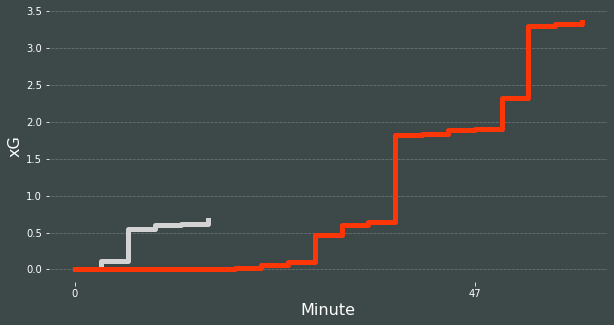

In [46]:
import matplotlib as mpl
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,5))
fig.set_facecolor('#3d4849')
ax.patch.set_facecolor('#3d4849')

#set up our base layer
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'

ax.grid(ls='dotted',lw=.5,color='lightgrey',axis='y',zorder=1)
spines = ['top','bottom','left','right']
for x in spines:
    if x in spines:
        ax.spines[x].set_visible(False)
        
plt.xticks([0,15,30,45,60,75,90])
plt.xlabel('Minute',fontname='Andale Mono',color='white',fontsize=16)
plt.ylabel('xG',fontname='Andale Mono',color='white',fontsize=16)
print(h_min)
print(a_min)
#plot the step graphs
ax.step(x=a_min,y=a_cumulative,color='#d3d3d3',label=ateam,linewidth=5,where='post')
ax.step(x=h_min,y=h_cumulative,color='#fd3607',label=ateam,linewidth=5,where='post')

In [47]:
xG = a_cumulative + h_cumulative
minute = a_min + h_min
teams = away + home

In [48]:
col_names = ['minute','xG','team']
df = pd.DataFrame([minute,xG,teams],index=col_names)
df = df.T
print(df)

   minute        xG        team
0       0         0     Lorient
1      14  0.115151     Lorient
2      16  0.547028     Lorient
3      21  0.599314     Lorient
4      57  0.619451     Lorient
5      71  0.666205     Lorient
6       0         0  Strasbourg
7       5  0.016727  Strasbourg
8      18  0.066259  Strasbourg
9      22  0.094961  Strasbourg
10     27  0.460571  Strasbourg
11     32  0.600365  Strasbourg
12     35  0.636967  Strasbourg
13     38  0.920052  Strasbourg
14     38  1.818025  Strasbourg
15     40  1.838469  Strasbourg
16     46   1.88297  Strasbourg
17     47  1.906068  Strasbourg
18     59  2.328568  Strasbourg
19     63  3.299523  Strasbourg
20     76  3.323341  Strasbourg
21     78  3.348484  Strasbourg


In [49]:
print(str(int(data_home[0]['season'])+1))
df.to_csv(r'../CSV/xG matchs/'+str(data_home[0]['season'])+'-'+str(int(data_home[0]['season'])+1)+'/xG_'+str(data_home[0]['h_team'])+'-'+str(data_home[0]['a_team'])+'.csv', index = False)

2022


In [50]:
print(data)

{'h': [{'id': '440228', 'minute': '5', 'result': 'MissedShots', 'X': '0.7440000152587891', 'Y': '0.49700000762939456', 'xG': '0.016727404668927193', 'player': 'Habib Diallo', 'h_a': 'h', 'player_id': '5769', 'situation': 'OpenPlay', 'season': '2021', 'shotType': 'RightFoot', 'match_id': '17940', 'h_team': 'Strasbourg', 'a_team': 'Lorient', 'h_goals': '4', 'a_goals': '0', 'date': '2021-10-31 14:00:00', 'player_assisted': 'Ibrahima Sissoko', 'lastAction': 'HeadPass'}, {'id': '440231', 'minute': '18', 'result': 'MissedShots', 'X': '0.874000015258789', 'Y': '0.32099998474121094', 'xG': '0.04953131452202797', 'player': 'Habib Diallo', 'h_a': 'h', 'player_id': '5769', 'situation': 'OpenPlay', 'season': '2021', 'shotType': 'LeftFoot', 'match_id': '17940', 'h_team': 'Strasbourg', 'a_team': 'Lorient', 'h_goals': '4', 'a_goals': '0', 'date': '2021-10-31 14:00:00', 'player_assisted': None, 'lastAction': 'None'}, {'id': '440233', 'minute': '22', 'result': 'MissedShots', 'X': '0.774000015258789', '